# Plotting and Comparing Cosine Similarity Distributions

By: Adam Li

Here I extract from every channel a 7x1 frequency vector from 0.5 seconds before vocalization to vocalization (time averaged). This results in a #channelsX7 feature vector for every word pair event. 

I compare same word pairings vs. different word pairings (e.g. BRICK_CLOCK vs BRICK_CLOCK and BRICK_CLOCK vs GLASS_JUICE) and produce the following:

1. Plot Histograms of cosine similarities
2. t-test or ks test between the distributions

In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools

import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [39]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
np.random.seed(123456789)  # for reproducibility, set random seed
distances = Distance.cosine # define distance metric to use
num_time_windows = 10
low_freq_bands = [0, 1]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
# print freq_bands
# print [freq_labels[i] for i in freq_bands]

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  70  total= 6720


In [40]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/blocks/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
            
    return data_dict

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list  
    
distances = Distance.cosine # define distance metric to use
def computeWithinDistances(mat):
    distance_list = np.array(())
    
    distance_list = []
    for idx in range(0, mat.shape[0]):
        for x in mat[idx+1:,:]:
            dist = distances(x,mat[idx,:])
            to_append = np.array(dist)
            distance_list.append(to_append)
            
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list

def createWordGroups(wordpairs):
    # create same group pairs
    for idx, pair in enumerate(wordpairs):
        same_word_group.append([pair, pair])

    # create reverse, and different groups
    for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
        if isReverse(pairs[0], pairs[1]):
            reverse_word_group.append([pairs[0], pairs[1]])
        else:
            diff_word_group.append([pairs[0], pairs[1]])
            
    return same_word_group, reverse_word_group, diff_word_group

def plotDescription(session, block):
    fig=plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
    plt.title(session + ' ' + block + ' within-block analysis')
    plt.grid(False)

def plotHistogramDistances(distances, session, block, wordpairtype):
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)
    plt.hist(distances, color='k', lw=3)
    plt.xlabel('Cosine Similarity n='+str(len(distances)))
    plt.ylabel('Frequency Count')
    plt.title(wordpairtype + ' Within-block pairwise distances in ' + session + ' with ' + block)
    plt.xlim([-1,1])
    plt.legend(r'n= %s'%(str(len(distances))))
    plt.tight_layout()
    
def createSameWordSimilarities(block_data, channels):
    same_word_distances = np.array(())
    
    ################# 02a: Same Words Cosine Distnace #################
    # extract channel data for same word group
    same_word_dict = {}
    for same_words in same_word_group:
        same_feature_mat = np.array(()) # initialize matrix to store feature vectors for each event

        for chan in channels: 
            ## 01: extract data to process - average across time 
            same_word_data = []
            same_word_key = same_words[0]
            probeOnTime = block_data['data'][same_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][same_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][same_word_key][str(chan)]['powerMat']

            ## 02: average across time and append frequency feature vector
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                feature_vect = np.mean(powerMat[i,freq_bands,vocalizationTime[i]-num_time_windows:vocalizationTime[i]-1],axis=1)
                same_word_data.append(np.ndarray.flatten(feature_vect))

            ## 03: append freq. feature vector per channel to each event
            if same_feature_mat.size == 0:
                same_feature_mat = np.array(same_word_data)
            else:
                same_feature_mat = np.append(same_feature_mat, np.array(same_word_data), axis=1)

        ## 04: do a pairwise comparison of all events in this word pair
        same_feature_mat = computeWithinDistances(same_feature_mat)
        same_word_dict[same_word_key] = same_feature_mat

    ## 05: convert into list of distances
    for key in same_word_dict.keys():
        if same_word_distances.size == 0:
            same_word_distances = same_word_dict[key]
        else:
            same_word_distances = np.append(same_word_distances, same_word_dict[key], axis=0)
    return same_word_distances

def createDiffWordSimilarities(block_data, channels):
    diff_word_distances = np.array(())
   
    ########################## 02b: DIFFERENT WORD PAIRS ########################################
    diff_word_dict = {}
    for diff_words in diff_word_group:
        diff_feature_mat1 = np.array(()) # initialize matrix to store feature vectors for each event
        diff_feature_mat2 = np.array(())

        # keys for different words
        diff_word1 = diff_words[0]
        diff_word2 = diff_words[1] 

        for chan in channels:    # loop through every channel
            # word keys and buffer lists
            diff_word_databuffer1 = []
            diff_word_databuffer2 = []

            ## 01: extract channel data from blockdata dictionary
            probeOnTime = block_data['data'][diff_word1][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][diff_word1][str(chan)]['timeVocalization']
            powerMat = block_data['data'][diff_word1][str(chan)]['powerMat']
            ## 02: average across time and append frequency feature vector
            for i in range(0, len(vocalizationTime)):
                feature_vect = np.mean(powerMat[i,freq_bands,vocalizationTime[i]-num_time_windows:vocalizationTime[i]-1],axis=1)
                diff_word_databuffer1.append(np.ndarray.flatten(feature_vect))
            ## 03:append freq. feature vector per channel to each event
            if diff_feature_mat1.size == 0:
                diff_feature_mat1 = np.array(diff_word_databuffer1)
            else:
                diff_feature_mat1 = np.append(diff_feature_mat1, np.array(diff_word_databuffer1), axis=1)

            probeOnTime = block_data['data'][diff_word2][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][diff_word2][str(chan)]['timeVocalization']
            powerMat = block_data['data'][diff_word2][str(chan)]['powerMat']
            ## 02: average across time and append frequency feature vector
            for i in range(0, len(vocalizationTime)):
                feature_vect = np.mean(powerMat[i,freq_bands,vocalizationTime[i]-num_time_windows:vocalizationTime[i]-1],axis=1)
                diff_word_databuffer2.append(np.ndarray.flatten(feature_vect))
            ## 03:append freq. feature vector per channel to each event
            if diff_feature_mat2.size == 0:
                diff_feature_mat2 = np.array(diff_word_databuffer2)
            else:
                diff_feature_mat2 = np.append(diff_feature_mat2, np.array(diff_word_databuffer2), axis=1)

        ## 04: pairwise comparison
        diff_word_dict['vs'.join(diff_words)] = computePairDistances(diff_feature_mat1, diff_feature_mat2)

    # convert into list of distances
    for key in diff_word_dict.keys():
        if diff_word_distances.size == 0:
            diff_word_distances = diff_word_dict[key]
        else:
            diff_word_distances = np.append(diff_word_distances, diff_word_dict[key], axis=0)
    return diff_word_distances

Analyzing session  session_1
On block:  BLOCK_0  using t-test
Same avg +/- std: 0.104  +/- 0.006
Different avg +/- std: 0.107  +/- 0.004
Same vs. Same comparison: 0.572
Same vs. Different Comparison: 0.702 

On block:  BLOCK_1  using t-test
Same avg +/- std: 0.090  +/- 0.006
Different avg +/- std: 0.089  +/- 0.004
Same vs. Same comparison: 0.242
Same vs. Different Comparison: 0.969 

On block:  BLOCK_2  using t-test
Same avg +/- std: 0.076  +/- 0.005
Different avg +/- std: 0.075  +/- 0.004
Same vs. Same comparison: 0.522
Same vs. Different Comparison: 0.896 

On block:  BLOCK_3  using t-test
Same avg +/- std: 0.119  +/- 0.006
Different avg +/- std: 0.115  +/- 0.004
Same vs. Same comparison: 0.794
Same vs. Different Comparison: 0.615 

On block:  BLOCK_4  using t-test
Same avg +/- std: 0.113  +/- 0.006
Different avg +/- std: 0.096  +/- 0.004
Same vs. Same comparison: 0.473
Same vs. Different Comparison: 0.017 

On block:  BLOCK_5  using t-test
Same avg +/- std: 0.173  +/- 0.005
Differen

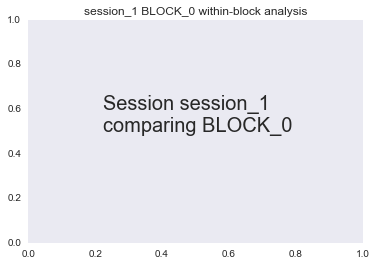

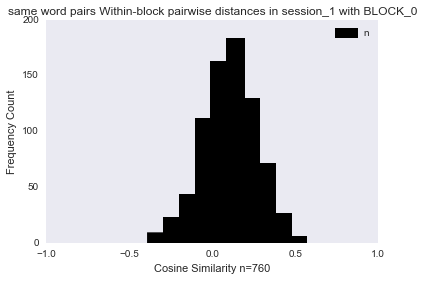

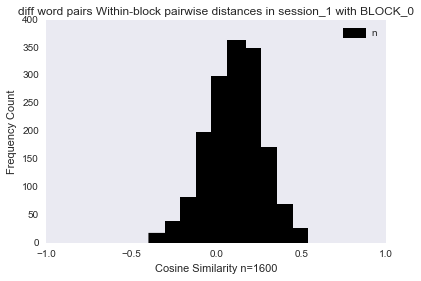

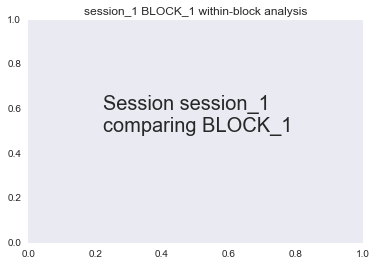

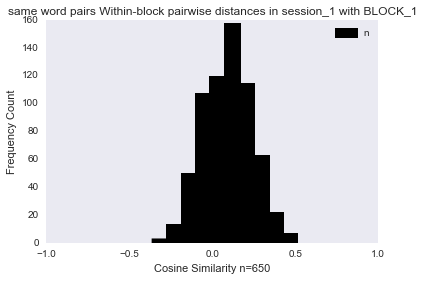

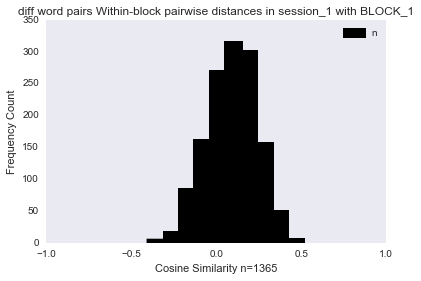

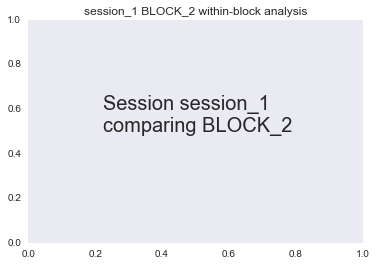

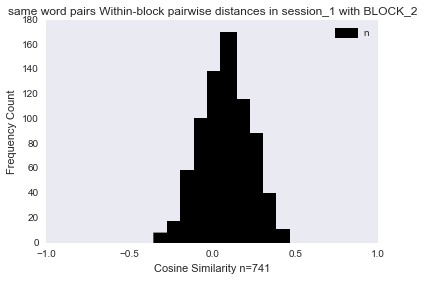

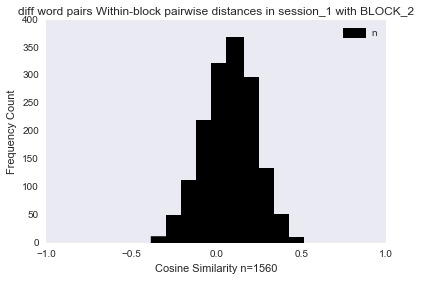

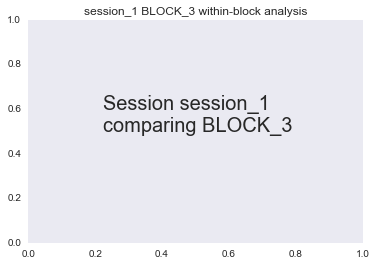

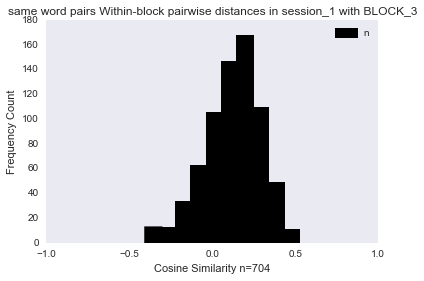

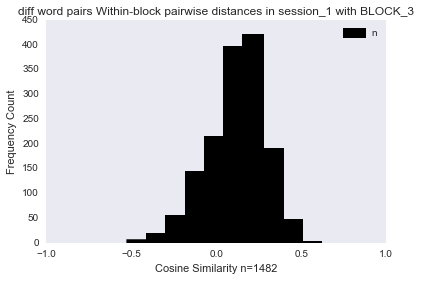

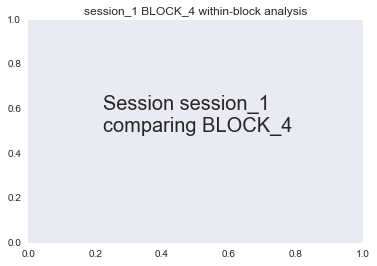

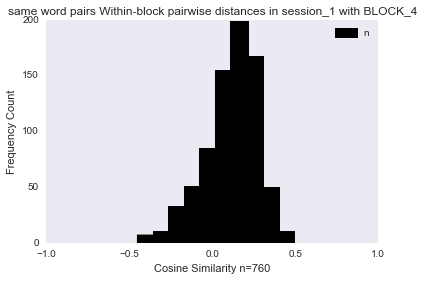

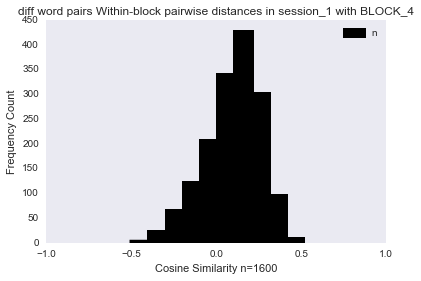

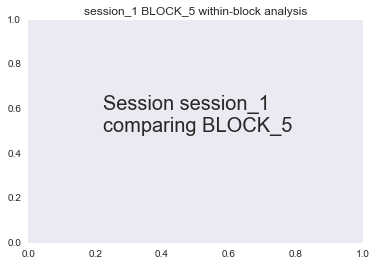

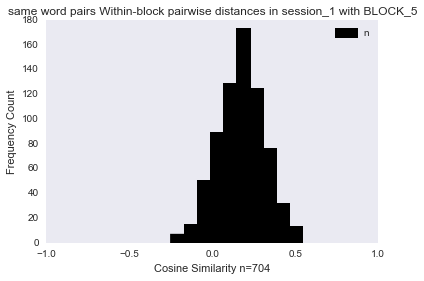

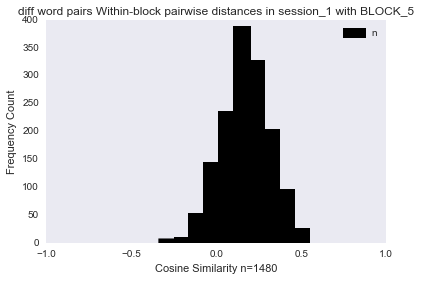

In [41]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034'
filedir = '../../condensed_data_' + subj + '/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
num_chans = 96
debug_on = 0

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block one at a time, analyze
    for i in range(0, 6):
#         print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = [] 
        
        ## 01: Create WordPair Groups
        same_word_group, reverse_word_group, diff_word_group = createWordGroups(wordpairs)
        
        #### plot meta information about which session and blocks we're analyzing
        plotDescription(session, block)
        
        ## 02: extract sessionblockdata dictionary for all channels
        block_data = extractSubjSessionBlockData(subj, session, block)
        channels = np.arange(1, num_chans+1, 1)
        
        same_word_distances = createSameWordSimilarities(block_data, channels)
        diff_word_distances = createDiffWordSimilarities(block_data, channels)
        
        if debug_on:
            print "done..."
            print "Example paired word feature matrix: ", diff_feature_mat2.shape
            print same_word_distances.shape
            print diff_word_distances.shape
        
        ##### 01: Plot Histogram of Cosine Similarities
        plotHistogramDistances(same_word_distances, session, block, 'same word pairs')
        plotHistogramDistances(diff_word_distances, session, block, 'diff word pairs')
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(same_word_distances.shape[0]), size=len(same_word_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(same_word_distances))) - set(random_subset))
        same_X = same_word_distances[random_subset]
        same_Y = same_word_distances[random_subset2]
        
        # sub-sample the diff_word_distances if using ks_test
#         stat, same_p_val = stats.ks_2samp(same_X, same_Y)
#         stat, diff_p_val = stats.ks_2samp(same_word_distances, diff_word_distances)
           
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, diff_p_val = stats.ttest_ind(same_word_distances, diff_word_distances)
        
        print "On block: ", block, " using t-test"
        print "Same avg +/- std: %0.3f" %np.mean(same_word_distances), ' +/- %0.3f' %stats.sem(same_word_distances)
        print "Different avg +/- std: %0.3f" %np.mean(diff_word_distances), ' +/- %0.3f' %stats.sem(diff_word_distances)
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val, "\n"
    break

# Discussion On NIH034



# Do NIH039 Now Below

In [42]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/sessions/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
            
    return data_dict

Analyzing subject:  NIH039  in  ../../condensed_data_NIH039/sessions/
Analyzing session  session_0
On block:  BLOCK_0  using t-test
Same avg +/- std: 0.065  +/- 0.008
Different avg +/- std: 0.074  +/- 0.006
Same vs. Same comparison: 0.122
Same vs. Different Comparison: 0.343 

On block:  BLOCK_1  using t-test
Same avg +/- std: 0.094  +/- 0.007
Different avg +/- std: 0.097  +/- 0.005
Same vs. Same comparison: 0.040
Same vs. Different Comparison: 0.778 

On block:  BLOCK_2  using t-test
Same avg +/- std: 0.047  +/- 0.009
Different avg +/- std: 0.057  +/- 0.006
Same vs. Same comparison: 0.341
Same vs. Different Comparison: 0.325 

On block:  BLOCK_3  using t-test
Same avg +/- std: 0.073  +/- 0.010
Different avg +/- std: 0.072  +/- 0.007
Same vs. Same comparison: 0.650
Same vs. Different Comparison: 0.930 

On block:  BLOCK_4  using t-test
Same avg +/- std: 0.064  +/- 0.007
Different avg +/- std: 0.066  +/- 0.005
Same vs. Same comparison: 0.382
Same vs. Different Comparison: 0.840 

On blo

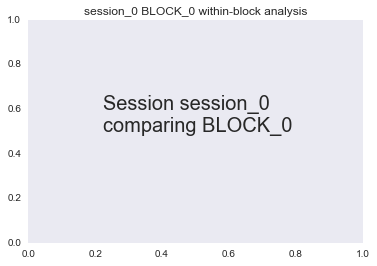

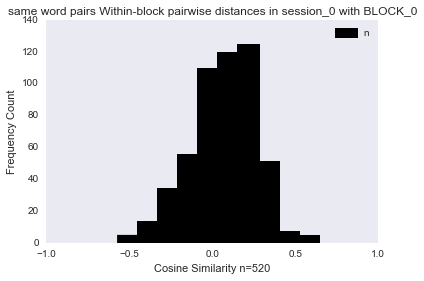

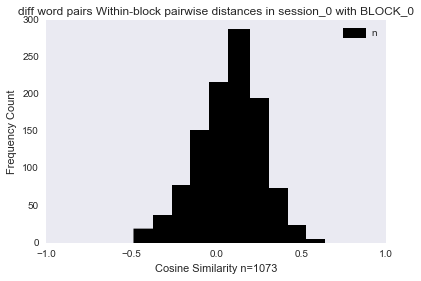

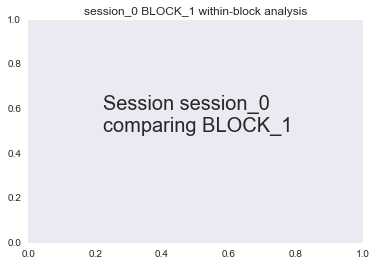

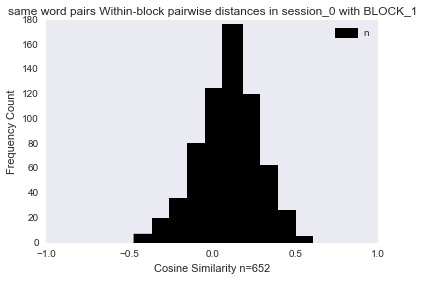

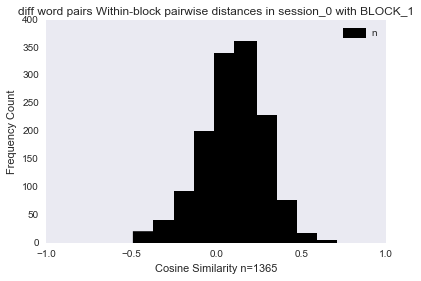

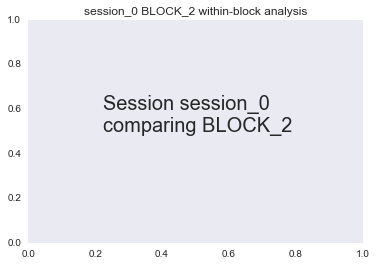

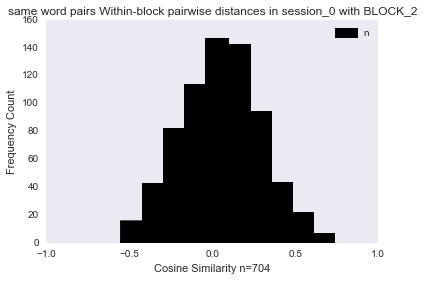

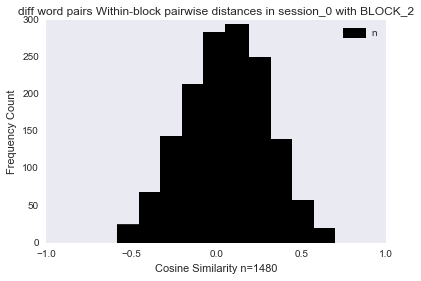

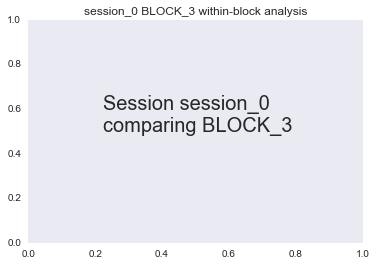

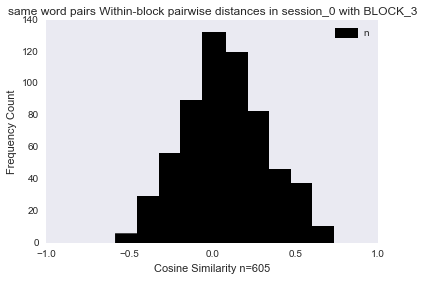

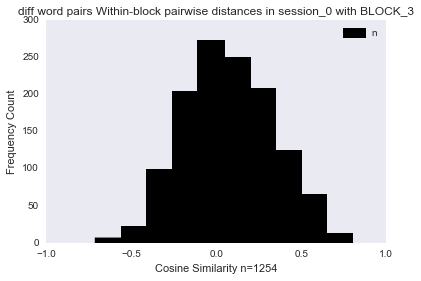

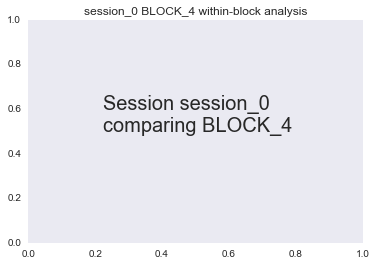

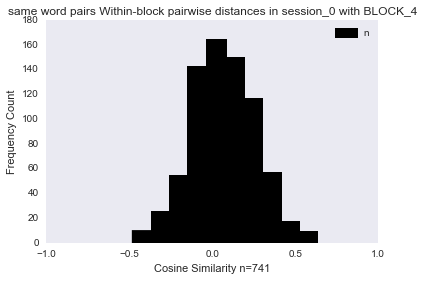

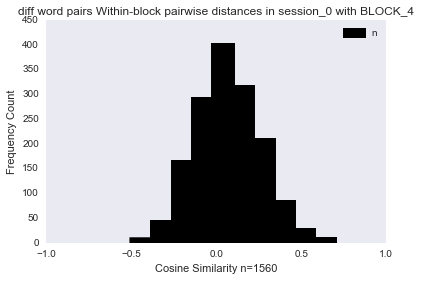

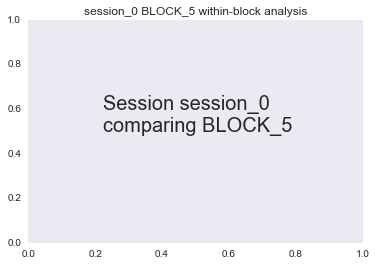

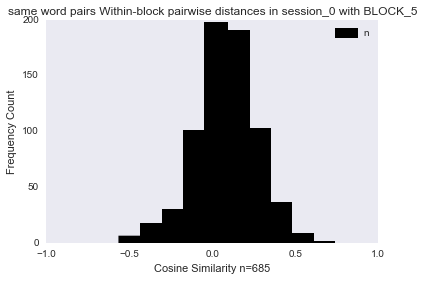

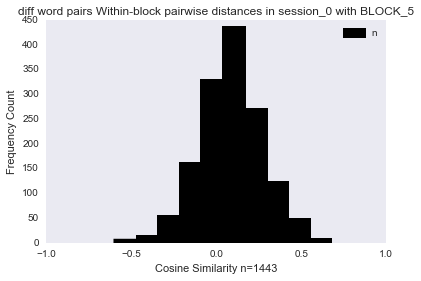

In [43]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH039'
filedir = '../../condensed_data_' + subj + '/sessions/'
sessions = os.listdir(filedir)
# sessions = sessions[2:]
num_chans = 72
debug_on = 0

print "Analyzing subject: ", subj, " in ", filedir
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block one at a time, analyze
    for i in range(0, 6):
#         print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = [] 
        
        ## 01: Create WordPair Groups
        same_word_group, reverse_word_group, diff_word_group = createWordGroups(wordpairs)
        
        #### plot meta information about which session and blocks we're analyzing
        plotDescription(session, block)
        
        ## 02: extract sessionblockdata dictionary for all channels
        block_data = extractSubjSessionBlockData(subj, session, block)
        channels = np.arange(1, num_chans+1, 1)
        
        same_word_distances = createSameWordSimilarities(block_data, channels)
        diff_word_distances = createDiffWordSimilarities(block_data, channels)
        
        if debug_on:
            print "done..."
            print "Example paired word feature matrix: ", diff_feature_mat2.shape
            print same_word_distances.shape
            print diff_word_distances.shape
        
        ##### 01: Plot Histogram of Cosine Similarities
        plotHistogramDistances(same_word_distances, session, block, 'same word pairs')
        plotHistogramDistances(diff_word_distances, session, block, 'diff word pairs')
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(same_word_distances.shape[0]), size=len(same_word_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(same_word_distances))) - set(random_subset))
        same_X = same_word_distances[random_subset]
        same_Y = same_word_distances[random_subset2]
        
        # sub-sample the diff_word_distances if using ks_test
#         stat, same_p_val = stats.ks_2samp(same_X, same_Y)
#         stat, diff_p_val = stats.ks_2samp(same_word_distances, diff_word_distances)
           
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, diff_p_val = stats.ttest_ind(same_word_distances, diff_word_distances)
        
        print "On block: ", block, " using t-test"
        print "Same avg +/- std: %0.3f" %np.mean(same_word_distances), ' +/- %0.3f' %stats.sem(same_word_distances)
        print "Different avg +/- std: %0.3f" %np.mean(diff_word_distances), ' +/- %0.3f' %stats.sem(diff_word_distances)
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val, "\n"
    break